# KNN으로 Hyperparameter Tuning 이해하기

## 0. 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML 
from IPython.core.interactiveshell import InteractiveShell
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings(action='ignore')
from sklearn.metrics import *
InteractiveShell.ast_node_interactivity = "all"
from sklearn.datasets import load_iris
iris = pd.read_csv('Iris.csv',encoding='utf-8') 
iris_1 = load_iris()
X = iris_1.data
y = iris_1.target

## 1. Preprocessing / EDA

가장 유명한 학습용 데이터인 iris이지만, 사실 저는 제대로 iris를 다뤄본적이 없습니다.... 이렇게 iris를 다뤄볼 기회를 주셔서 감사합니다. 한번 열심히 해보겠습니다. 

일단 iris data 여기저기 살펴보도록 하겠습니다!

In [2]:
iris.head()
iris.info()
iris.describe()
iris["Species"].value_counts()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
Id               150 non-null int64
SepalLengthCm    150 non-null float64
SepalWidthCm     150 non-null float64
PetalLengthCm    150 non-null float64
PetalWidthCm     150 non-null float64
Species          150 non-null object
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,75.500000,5.843333,3.054000,3.758667,1.198667
std,43.445368,0.828066,0.433594,1.764420,0.763161
min,1.000000,4.300000,2.000000,1.000000,0.100000
25%,38.250000,5.100000,2.800000,1.600000,0.300000
50%,75.500000,5.800000,3.000000,4.350000,1.300000
75%,112.750000,6.400000,3.300000,5.100000,1.800000
max,150.000000,7.900000,4.400000,6.900000,2.500000


Iris-setosa        50
Iris-virginica     50
Iris-versicolor    50
Name: Species, dtype: int64

- 변수명과 의미를 정리하였을 때 다음과 같습니다.

|변수명|의미|
|-|-|
Id|id
SepalLengthCm|Length of the sepal (in cm),꽃받침의 길이|
SepalWidthCm|Width of the sepal (in cm),꽃받침의 폭|
PetalLengthCm|Length of the petal (in cm),꽃잎의 길이|
PetalWidthCm|Width of the petal (in cm),꽃잎의 폭|
Species|Species name|


- iris data는 id를 포함한 6개의 columns으로 구성되어 있습니다.
- 직관적으로 봤을때, 변수간 단위의 차이가 두드러지게 있는 것은 아닌 것으로 판단 됩니다. 
- data의 갯수는 150개 이며, Species를 제외한 데이터가 수치형으로 되어있습니다. 
- Species를 제외한 나머지 변수들의 평균과 표준편차 등의 정보를 확인 할 수 있었습니다. 
- Species는 versicolor,setosa,virginica 가 50개씩 균등하게 있음을 확인 할 수 있었습니다.

다음으로는 결측치가 있는지 확인해 보도록 하겠습니다. 

In [3]:
iris.isnull().sum(axis=0)

Id               0
SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64

결측치가 없는 깔끔한 데이터인 것을 알 수 있습니다. (역시 교육용 데이터)

그렇다면 이러한 데이터의 분포를 그래프를 통해 확인해보도록 하겠습니다.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002047927DAC8>,
      dtype=object)

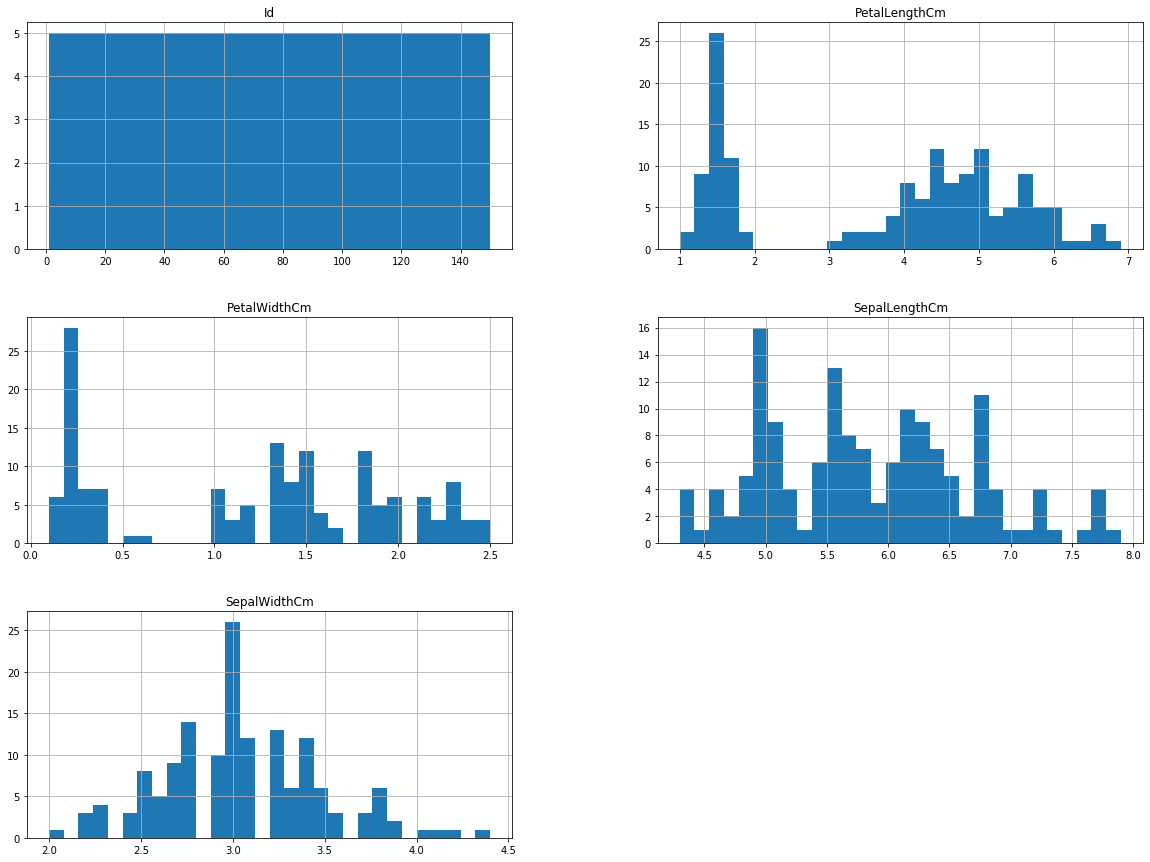

In [4]:
iris.hist(bins=30,figsize=(20,15)) #figsize를 통해 plot 크기 조절하고 분포를 확인해 보았습니다. 
plt.show()

이번에는 꽃받침과 꽃잎에 대해서 각각 길이와 너비 분포가 어떻게 형성되어있는지 확인해 보도록 하겠습니다. 

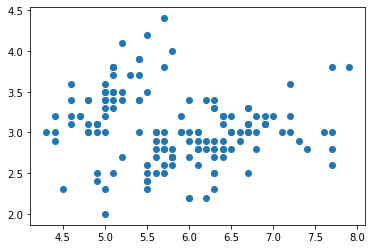

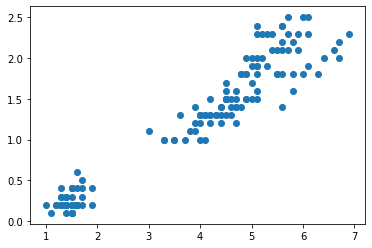

In [5]:
plt.scatter(x=iris['SepalLengthCm'],y=iris['SepalWidthCm'])
plt.show()

plt.scatter(x=iris['PetalLengthCm'],y=iris['PetalWidthCm'])
plt.show()

In [6]:
iris.data = iris.iloc[:, 1:5]

길이와 너비의 관계는 다음과 같이 분류를 하기에 바람직?하게 나눠져있음을 확인 할 수 있습니다.
다음은 iris의종류에 따라서 인코딩을 해보도록 하겠습니다 .

In [7]:
def encoding (x):
    if x == 'Iris-versicolor':
        return 0
    elif x == 'Iris-setosa':
        return 1
    else:
        return 2
iris.target = iris.iloc[:,5].apply(encoding)
iris.target

0      1
1      1
2      1
3      1
4      1
      ..
145    2
146    2
147    2
148    2
149    2
Name: Species, Length: 150, dtype: int64

## 2. GridSearchCV & 3. Evaluation

위에서 나누어준 data와 target을 기준으로 0.3 0.7 비율로 train과 test를 나눠주도록 하겠습니다. 

In [8]:
#iris.data = iris.data.astype(('int'))
#iris.target = iris.target.astype(('int'))
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.2, random_state=0)

grid_search를 진행하기위해 다음과 같이 세팅과정을 거쳤습니다.
후보는 위에서 흩어진 정도를 봤을때, 그렇게 많은 k의 개수가 필요한 것은 아닌 것 같다고 판단하여 비교적 작은? k개의 후보를 설정하였고
weights는 균등한 voting을 주는 경우와 , weighted knn에 사용되는 distance를 사용하였고
군집간의 거리는 euclidean과 manhattan을 후보로 두었습니다. 

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    'n_neighbors' : [3,5,7,9,11,13,15,17,19],
    'weights' : ['uniform','distance'],
    'metric' : ['euclidean', 'manhattan'] 
}

grid_search = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    verbose = 1,
    cv = 3,
    n_jobs = -1
)

In [10]:
gs_results = grid_search.fit(X_train,y_train) #train set에 대해서 grid search를 진행하였습니다. 

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    2.9s finished


In [11]:
print("가장 좋은 결과를 얻는 그리드 : {}".format(gs_results.best_params_))
print("Best Cross-validatiy Score는 : {}".format(gs_results.best_score_))
print("test에 대해 grid_seach 알고리즘을 적용하면 : {}".format(gs_results.score(X_test,y_test)))

가장 좋은 결과를 얻는 그리드 : {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
Best Cross-validatiy Score는 : 0.9666666666666667
test에 대해 grid_seach 알고리즘을 적용하면 : 1.0


test에 대해 grid_search 알고리즘을 적용하면 1에 가까울정도로 높은 수준으로 점수가 나오는 것을 확인 할 수 있었습니다. 
추가적으로 꽃잎과 꽃받침 분포도 나누어 보았습니다. 위와 동일하게  train set과 train set 0.7 : 0.3 비율로 분리하였습니다. 

In [12]:
X_train_Sepal, X_test_Sepal, y_train_Sepal, y_test_Sepal = train_test_split(iris.iloc[:, [1]], iris.iloc[:, [2]], test_size=0.3, random_state=0)
X_train_Petal, X_test_Petal, y_train_Petal, y_test_Petal = train_test_split(iris.iloc[:, [3]], iris.iloc[:, [4]], test_size=0.3, random_state=0)
# Unknown label type: 'continuous'라는 에러를 해결하기 위해서 int로 type을 변화시켜 주었습니다. 원래 연속적인 데이터인거 같은데... 왜인지는 모르겠습니다. 
X_train_Sepal = X_train_Sepal.astype(('int'))
X_test_Sepal  = X_test_Sepal.astype(('int'))

y_train_Sepal = y_train_Sepal.astype(('int'))
y_test_Sepal = y_test_Sepal.astype(('int'))

X_train_Petal = X_train_Petal.astype(('int'))
X_test_Petal= X_test_Petal.astype(('int'))

y_train_Petal = y_train_Petal.astype(('int'))
y_test_Petal= y_test_Petal.astype(('int'))

In [13]:
param_grid = {
    'n_neighbors' : [3,5,7,9,11,13,15,17,19],
    'weights' : ['uniform','distance'],
    'metric' : ['euclidean', 'manhattan'] 
}

grid_search = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    verbose = 1,
    cv = 3,
    n_jobs = -1
)

In [14]:
gs_results_Sepal = grid_search.fit(X_train_Sepal,y_train_Sepal) #Sepal에 대해서도 grid search를 진행하였습니다. 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    0.1s finished


In [15]:
gs_results_Petal = grid_search.fit(X_train_Petal,y_train_Petal) #Petal에 대해서도 역시 grid search를 진행하였습니다. 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    0.1s finished


일단 모두 같은 Fitting 3 folds for each of 36 candidates, totalling 108 fits로 나타나고 있는데 Evaluation을 해보도록 하겠습니다. 

결과는 다음과 같습니다

In [16]:
print("가장 좋은 결과를 얻는 그리드: {}".format(gs_results_Sepal.best_params_))
print("Best Cross-validatiy Score: {}".format(gs_results_Sepal.best_score_))
print("test에 대해 grid_seach 알고리즘을 적용하면: {}".format(gs_results_Sepal.score(X_test_Sepal,y_test_Sepal)))

가장 좋은 결과를 얻는 그리드: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
Best Cross-validatiy Score: 0.8666666666666667
test에 대해 grid_seach 알고리즘을 적용하면: 0.28888888888888886


In [17]:
print("가장 좋은 결과를 얻는 그리드: {}".format(gs_results_Petal.best_params_))
print("Best Cross-validatiy Score: {}".format(gs_results_Petal.best_score_))
print("test에 대해 grid_seach 알고리즘을 적용하면 Test Score: {}".format(gs_results_Petal.score(X_test_Petal,y_test_Petal)))

가장 좋은 결과를 얻는 그리드: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
Best Cross-validatiy Score: 0.8666666666666667
test에 대해 grid_seach 알고리즘을 적용하면 Test Score: 0.8666666666666667


알고리즘을 적용하였을때 점수가 매우 떨어지는 것을 확인할 수 있었고, petal에 대해서는 높은수준의 점수가 나타나는 것을 확인할 수 있었습니다. 